In [1]:
# ==============================================================================
# 1. 导入所需库
# ==============================================================================
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm

# 设置中文字体，用于在Matplotlib中正确显示中文标签
# 请确保您的环境中已安装'SimHei'字体，否则可以替换为其他支持中文的字体
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题
except Exception as e:
    print(f"中文字体设置失败，请检查是否已安装SimHei字体: {e}")
    print("matplotlib中的中文标签可能无法正常显示。")

2025-05-29 12:34:36.710649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748522076.895350      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748522076.948978      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ==============================================================================
# 2. 加载数据并进行预处理
# ==============================================================================
print("--- 步骤 2: 加载并预处理数据 ---")
# 替换为您的数据路径
# 在Kaggle环境中通常是 /kaggle/input/paddy-disease-classification/
# 在本地环境中请修改为您的实际路径
try:
    train_images_path = r"/kaggle/input/paddy-disease-classification/train_images"
    test_images_path = r"/kaggle/input/paddy-disease-classification/test_images"
    # 检查路径是否存在
    if not os.path.exists(train_images_path):
        raise FileNotFoundError
except FileNotFoundError:
    print("未找到Kaggle默认数据路径，请手动修改 'train_images_path' 和 'test_images_path' 为您的本地路径。")
    # 在此处设置您的本地路径作为备用
    train_images_path = r"请替换为您的训练集路径"
    test_images_path = r"请替换为您的测试集路径"


# 为训练数据创建一个包含数据增强的生成器
train_datagen = ImageDataGenerator(
    rescale=1./255,          # 归一化
    validation_split=0.2,    # 划分20%的数据作为验证集
    rotation_range=30,       # 随机旋转角度
    width_shift_range=0.2,   # 随机水平平移
    height_shift_range=0.2,  # 随机垂直平移
    shear_range=0.2,         # 随机剪切变换
    zoom_range=0.2,          # 随机缩放
    horizontal_flip=True,    # 随机水平翻转
    fill_mode='nearest'
)

# 验证集生成器只需归一化，不需要数据增强
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# 创建训练数据生成器
train_generator = train_datagen.flow_from_directory(
    train_images_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training', # 指定为训练子集
    shuffle=True
)

# 创建验证数据生成器
val_generator = validation_datagen.flow_from_directory(
    train_images_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation', # 指定为验证子集
    shuffle=False
)

# 保存类别索引，用于后续解码
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
print("数据加载与预处理完成。")

--- 步骤 2: 加载并预处理数据 ---
Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.
数据加载与预处理完成。



--- 步骤 3: 数据可视化 ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/tmp/ipykernel_35/4147357139.py:14: UserWarning: Glyph 27700 (\N{CJK UNIFIED IDEOGRAPH-6C34}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/4147357139.py:14: UserWarning: Glyph 31291 (\N{CJK UNIFIED IDEOGRAPH-7A3B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/4147357139.py:14: UserWarning: Glyph 30149 (\N{CJK UNIFIED IDEOGRAPH-75C5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/4147357139.py:14: UserWarning: Glyph 23475 (\N{CJK UNIFIED IDEOGRAPH-5BB3}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/4147357139.py:14: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_35/4147357139.py:14: UserWarning

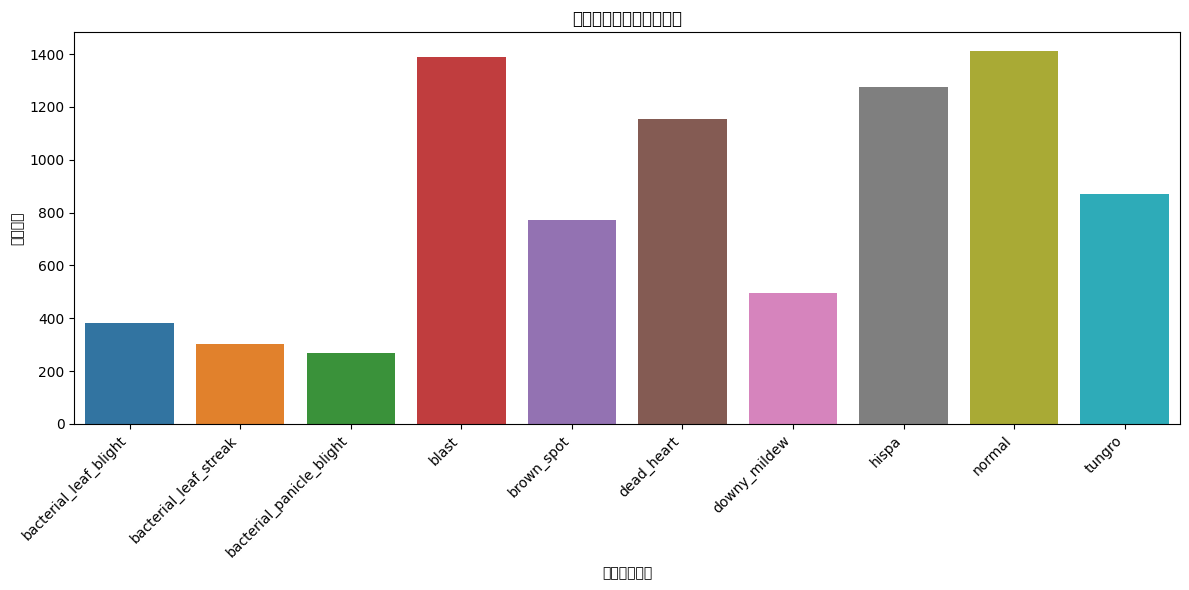

/tmp/ipykernel_35/4147357139.py:28: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_35/4147357139.py:28: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_35/4147357139.py:28: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_35/4147357139.py:28: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_35/4147357139.py:28: UserWarning: Glyph 23637 (\N{CJK UNIFIED IDEOGRAPH-5C55}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/tmp/ipykernel_35/4147357139.py:28: UserWarning: Glyph 31034 (\N{CJK UNIFIED IDEOGRAPH-793A}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/usr/local/lib/python3.11/di

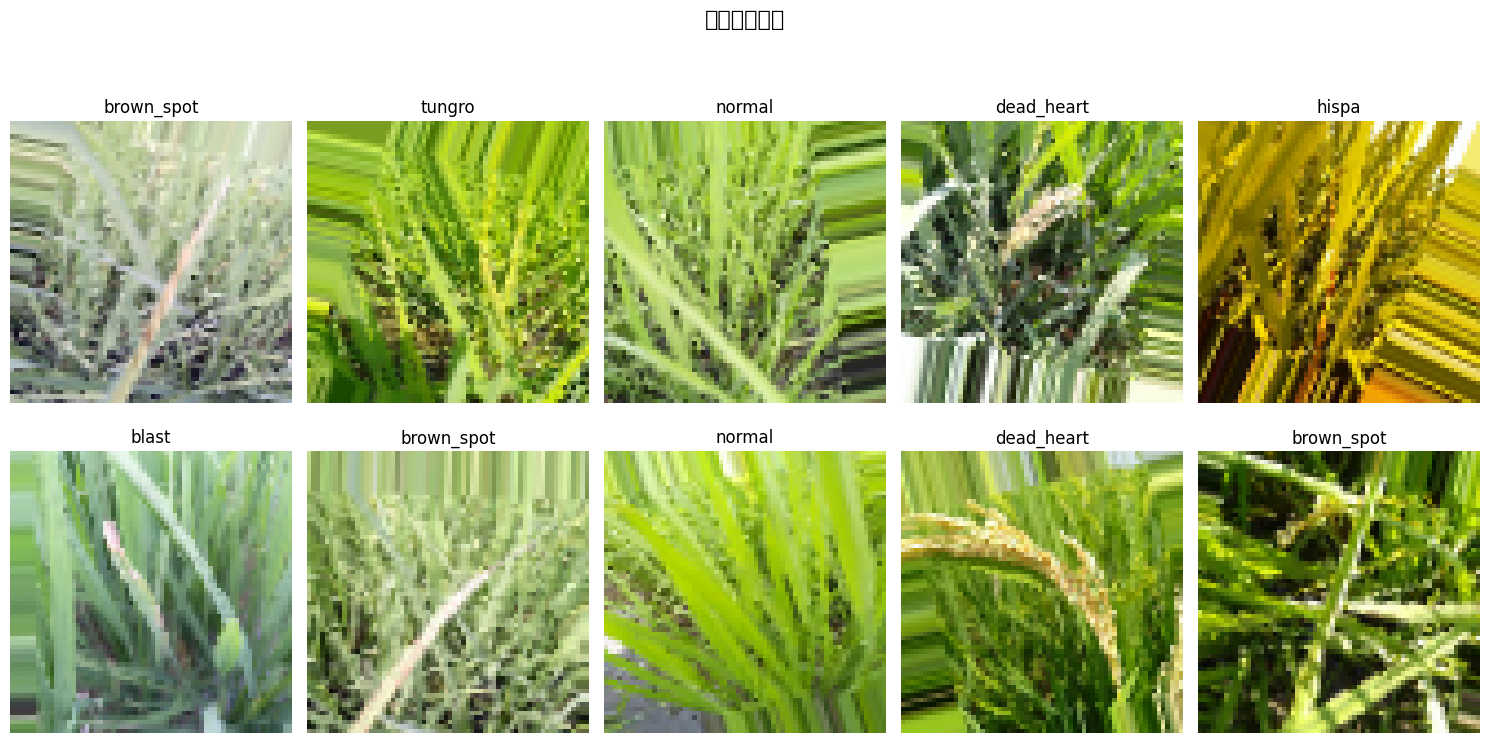

In [3]:
# ==============================================================================
# 3. 数据可视化
# ==============================================================================
print("\n--- 步骤 3: 数据可视化 ---")
# 3.1 类别分布可视化
class_counts = np.bincount(train_generator.classes)
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=class_counts)
plt.title('每个类别的图像分布情况')
plt.xlabel('水稻病害类别')
plt.ylabel('图像数量')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3.2 样本图像可视化
images, labels = next(train_generator)
class_labels = list(train_generator.class_indices.keys())
plt.figure(figsize=(15, 8))
for i in range(min(10, len(images))):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    class_name = class_labels[np.argmax(labels[i])]
    plt.title(class_name)
    plt.axis("off")
plt.suptitle('数据样本展示', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [4]:
# ==============================================================================
# 4. 构建优化的CNN模型
# ==============================================================================
print("\n--- 步骤 4: 构建优化的CNN模型 ---")
model = models.Sequential([
    Input(shape=(64, 64, 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

I0000 00:00:1748522098.463033      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



--- 步骤 4: 构建优化的CNN模型 ---


I0000 00:00:1748522098.463705      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,144,138 (4.36 MB)

 Trainable params: 1,143,690 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# ==============================================================================
# 5. 智能训练模型
# ==============================================================================
print("\n--- 步骤 5: 开始智能训练模型 ---")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_paddy_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)
print("模型训练完成。")


--- 步骤 5: 开始智能训练模型 ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1748522104.187616     116 service.cc:148] XLA service 0x7ab0a80112d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748522104.188459     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748522104.188483     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748522104.621337     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/261 ━━━━━━━━━━━━━━━━━━━━ 34:26 8s/step - accuracy: 0.0938 - loss: 4.3506

I0000 00:00:1748522108.195488     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


261/261 ━━━━━━━━━━━━━━━━━━━━ 109s 390ms/step - accuracy: 0.1544 - loss: 2.8539 - val_accuracy: 0.1589 - val_loss: 11.9020
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step - accuracy: 0.1858 - loss: 2.2161 - val_accuracy: 0.2484 - val_loss: 2.1631
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.2268 - loss: 2.1491 - val_accuracy: 0.2740 - val_loss: 2.0695
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step - accuracy: 0.2329 - loss: 2.1110 - val_accuracy: 0.2778 - val_loss: 2.0046
Epoch 5/50
170/261 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 0.2457 - loss: 2.0805

In [ ]:
# ==============================================================================
# 6. 评估模型性能
# ==============================================================================
print("\n--- 步骤 6: 评估模型性能 ---")
# 6.1 绘制准确率与损失曲线
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='训练损失 (Train Loss)')
plt.plot(history.history['val_loss'], label='验证损失 (Val Loss)')
plt.title('损失函数曲线')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='训练准确率 (Train Acc)')
plt.plot(history.history['val_accuracy'], label='验证准确率 (Val Acc)')
plt.title('准确率曲线')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 6.2 生成分类报告和混淆矩阵
print("\n加载性能最佳的模型进行最终评估...")
best_model = models.load_model('best_paddy_model.keras')
val_generator.reset()
y_pred_proba = best_model.predict(val_generator, steps=len(val_generator), verbose=1)
y_pred_label = np.argmax(y_pred_proba, axis=1)
y_true = val_generator.classes
class_names_report = list(val_generator.class_indices.keys())

print("\n================== 分类报告 ==================\n")
report = classification_report(y_true, y_pred_label, target_names=class_names_report)
print(report)

print("\n================== 混淆矩阵 ==================\n")
cm = confusion_matrix(y_true, y_pred_label)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names_report)
fig, ax = plt.subplots(figsize=(10, 10))
cmd.plot(ax=ax, cmap='Blues', xticks_rotation=45)
ax.set_title('验证集上的混淆矩阵')
plt.show()

In [ ]:
# ==============================================================================
# 7. 在测试集上进行预测
# ==============================================================================
print("\n--- 步骤 7: 在测试集上进行预测 ---")
predictions = []
try:
    test_filenames = sorted(os.listdir(test_images_path))
    for fname in tqdm(test_filenames, desc='正在预测测试集...'):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(test_images_path, fname)
            img = image.load_img(path, target_size=(64, 64))
            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            pred = best_model.predict(img_array, verbose=0)
            class_idx = np.argmax(pred)
            label = inv_class_indices[class_idx]
            predictions.append((fname, label))
    print("预测完成！")
except FileNotFoundError:
    print(f"测试集路径 '{test_images_path}' 未找到，跳过测试集预测。")

In [ ]:
# ==============================================================================
# 8. 保存提交文件
# ==============================================================================
if predictions:
    print("\n--- 步骤 8: 保存提交文件 ---")
    print("正在将预测结果保存到 submission.csv ...")
    df = pd.DataFrame(predictions, columns=["image_id", "label"])
    df.to_csv("submission.csv", index=False)
    print("文件已保存！")
    print(df.head())
else:
    print("\n由于未进行预测，无法生成submission.csv文件。")